## Imports

In [13]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

import shap

import pickle
import sys

sys.path.append("../")
from prediction.loss import *
from prediction.data_structures import *
from prediction.model import *

## Data

In [14]:
# single cell data
PATH_TO_DATA = '/ems/elsc-labs/habib-n/yuval.rom/500/DeepDynamics/prediction/data/500.h5ad'
data = sc.read_h5ad(PATH_TO_DATA)
data

AnnData object with n_obs × n_vars = 437 × 91
    obs: 'batches', 'main.batch', 'clusters', 'core'
    var: 'class', 'grouping.by', 'cell.type', 'community', 'sub.community'
    uns: 'cell.types', 'celmod', 'communities', 'excluded.states', 'leiden', 'neighbors', 'ss.cor', 'trait.analysis', 'trajectories', 'tsne', 'umap'
    obsm: 'QCs', 'X_all_3d_phate', 'X_core_phate', 'X_tsne', 'X_umap', 'communities', 'meta.data', 'risk.alleles', 'sub.communities'
    layers: 'counts', 'sqrt.prev'
    obsp: 'similarity_X_all_3d_phate', 'similarity_X_core_phate', 'similarity_X_tsne', 'similarity_X_umap'

In [15]:
# Filtering to only the most confident cell states (68)
cell_corr_data = data.uns['celmod']['test.corrs']
cell_state_filter = cell_corr_data.index[(cell_corr_data['adj.pval'] < 0.005) & (cell_corr_data['corr'] > 0)]
cell_state_filter.shape

(58,)

In [16]:
shared_bulk_data_mask = pd.read_csv('/ems/elsc-labs/habib-n/yuval.rom/500/DeepDynamics/prediction/data/shared_bulk_data_0.005.csv', index_col=0)

In [17]:
# This is the bulk samples that do not appears on the single cell data, with filtered cell types
unshared_bulk_data = data.uns['celmod']['avg.predicted.prop']['validation'][cell_state_filter]
unshared_bulk_data.shape

(673, 58)

In [18]:
all_bulk_data = pd.concat((shared_bulk_data_mask, unshared_bulk_data))
all_bulk_data.shape

(1044, 58)

## Load model

In [19]:
model_thin = ProbModel()
model_thin.load_state_dict(torch.load('/ems/elsc-labs/habib-n/yuval.rom/500/DeepDynamics/prediction/weights/model.pth'))

<All keys matched successfully>

## Explainability

In [21]:
shap.initjs()
def model_wrapper(x):
    x_tensor = torch.tensor(x).float()
    y_pred = model_thin(x_tensor)
    return y_pred.detach().numpy()


Using 1044 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1044 [00:00<?, ?it/s]

100%|██████████| 1044/1044 [1:10:07<00:00,  4.03s/it]


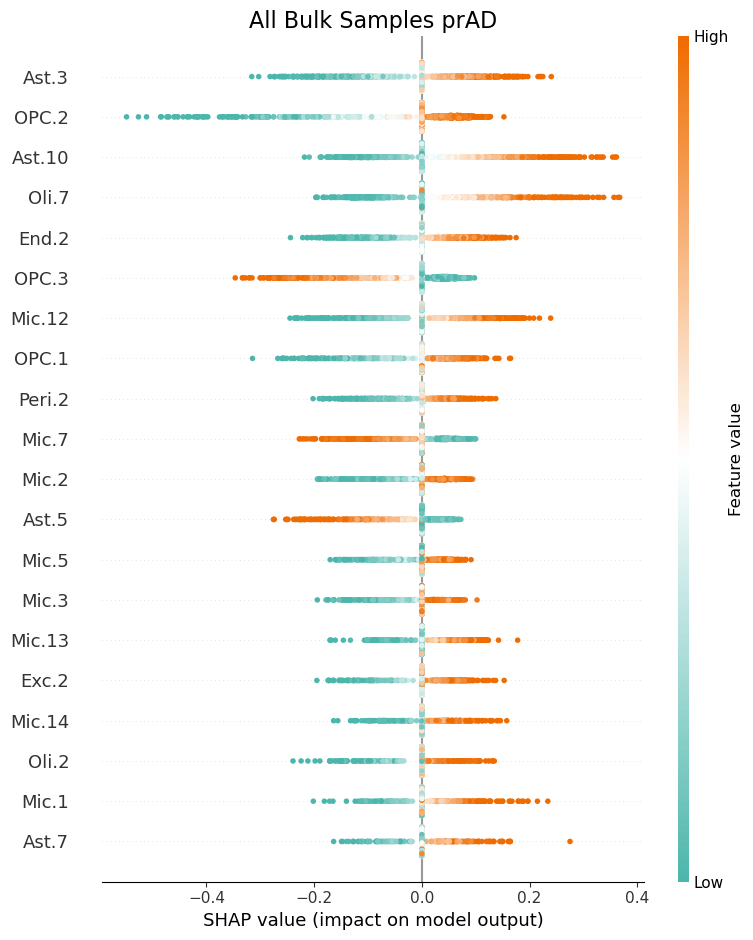

Using 1044 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1044/1044 [1:08:14<00:00,  3.92s/it]


<Figure size 640x480 with 0 Axes>

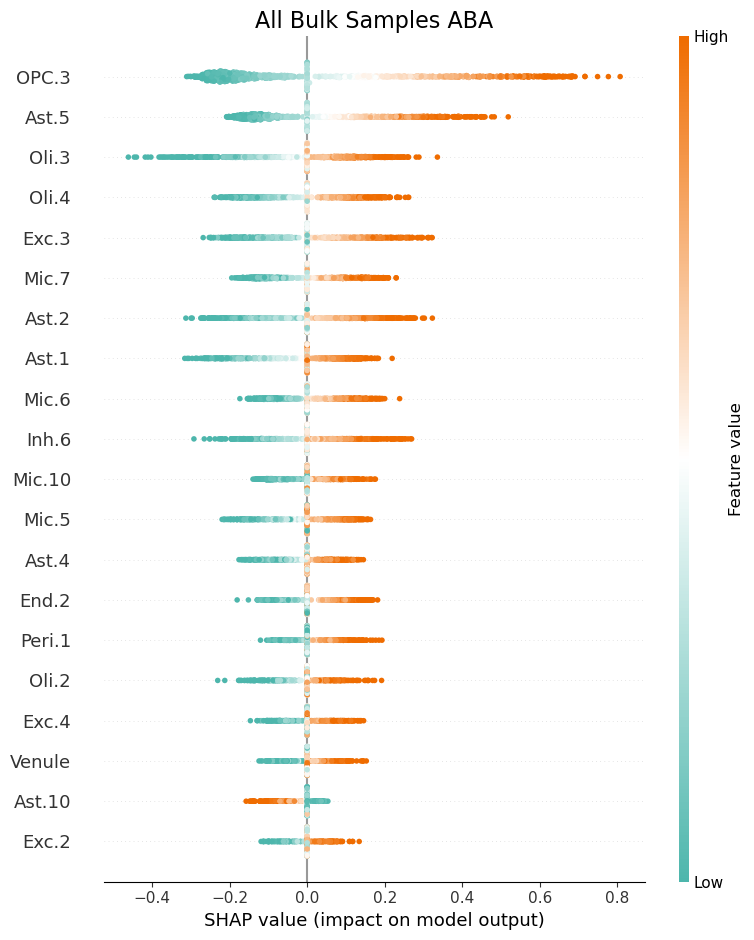

Using 1044 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1044/1044 [1:10:29<00:00,  4.05s/it]


<Figure size 640x480 with 0 Axes>

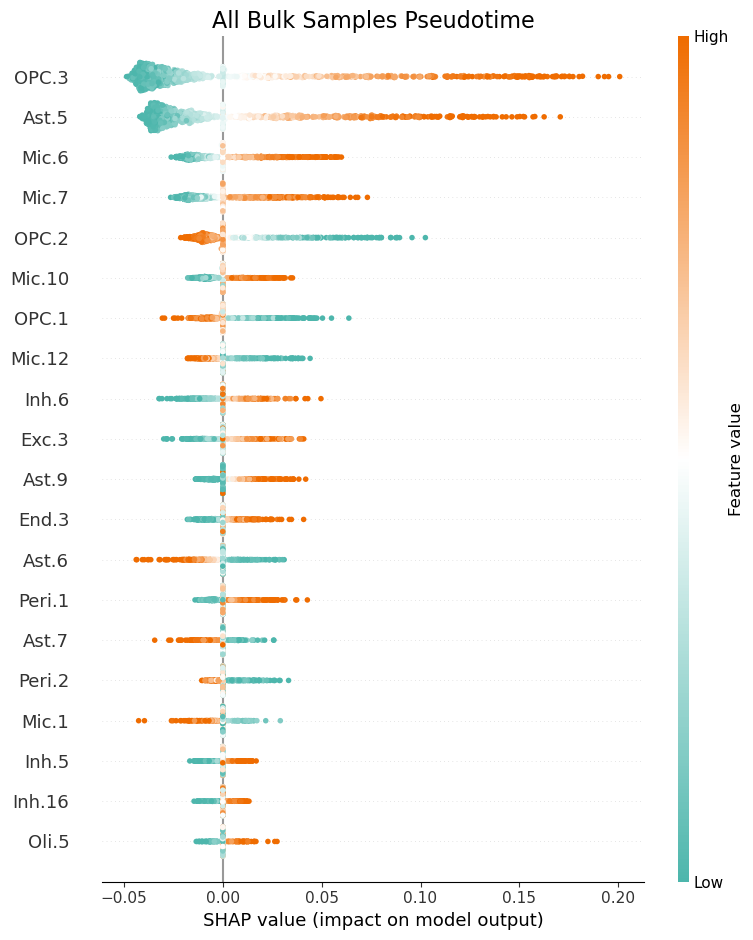

<Figure size 640x480 with 0 Axes>

In [23]:
titles = ['prAD', 'ABA', 'Pseudotime']
for i in range(len(titles)):
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Create a custom color map
    from matplotlib.colors import LinearSegmentedColormap
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["#4db6ac", "#FFFFFF", "#ef6c00"])
    explainer = shap.KernelExplainer(model_wrapper, all_bulk_data)
    shap_values = explainer(all_bulk_data.values[0:,:])


    shap.summary_plot(
        shap_values[:, :, i],
        all_bulk_data,
        plot_type='dot',
        feature_names=all_bulk_data.columns,
        cmap=custom_cmap,
        show=False
    )

    plt.title(f'All Bulk Samples {titles[i]}', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'shap_analysis_{titles[i]}.pdf')

In [ ]:
# with open('bulk/kernel_shap_values.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)

In [ ]:
shared_bulk_data_mask.shape, unshared_bulk_data.shape

((371, 58), (673, 58))

In [ ]:
with open('./data/kernel_shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [ ]:
with open('./data/explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)